#  AI Tinkerers Challenge Submission 


Text cleaning and plotting functions are from [here](https://www.kaggle.com/code/faressayah/sentiment-model-with-tensorflow-transformers). Tokenization steps are modified from the same source.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import transformers
from transformers import AutoTokenizer
from transformers import TFAutoModel
from datasets import load_dataset
from tensorflow.keras.mixed_precision import set_global_policy

In [2]:
print(tf.__version__)
print(transformers.__version__)

2.10.1
4.40.1


In [3]:
gpu = tf.config.list_physical_devices()[1]
tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
set_global_policy('mixed_float16') # mixed-precision training

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


## Preliminaries

In [5]:
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")
train = dataset['train'].to_pandas()
test = dataset['validation'].to_pandas()

train = train.groupby('label').head(1000)
test = train.groupby('label').head(300)

def sample_labels(df, n_per_label):
    return df.groupby('label').apply(lambda x: x.sample(n=n_per_label)).reset_index(drop=True)

val = sample_labels(test, 150)
sampled_indices = val.index
test = test.drop(sampled_indices).groupby('label').head(150).reset_index(drop=True)

In [6]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
    
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text 

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

train['text'] = train['text'].apply(lambda x : remove_url(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
train['text'] = train['text'].apply(lambda x : decontraction(x))
train['text'] = train['text'].apply(lambda x : seperate_alphanumeric(x))
train['text'] = train['text'].apply(lambda x : unique_char(cont_rep_char,x))

val['text'] = val['text'].apply(lambda x : remove_url(x))
val['text'] = val['text'].apply(lambda x : remove_punct(x))
val['text'] = val['text'].apply(lambda x : remove_emoji(x))
val['text'] = val['text'].apply(lambda x : decontraction(x))
val['text'] = val['text'].apply(lambda x : seperate_alphanumeric(x))
val['text'] = val['text'].apply(lambda x : unique_char(cont_rep_char,x))

test['text'] = test['text'].apply(lambda x : remove_url(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : decontraction(x))
test['text'] = test['text'].apply(lambda x : seperate_alphanumeric(x))
test['text'] = test['text'].apply(lambda x : unique_char(cont_rep_char,x))

In [7]:
seq_len = 256
batch_size = 8

model_name = "google/bert_uncased_L-2_H-128_A-2"

tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

x_train = tokenizer(
    train['text'].tolist(), 
    max_length=seq_len, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True, 
    return_tensors='tf'
)

x_val = tokenizer(
    val['text'].tolist(), 
    max_length=seq_len, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True, 
    return_tensors='tf'
)

x_test = tokenizer(
    test['text'].tolist(), 
    max_length=seq_len, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True, 
)

y_train = train['label'].values
y_val = val['label'].values
y_test = test['label'].values


def map_func(input_ids, attention_mask):
    return {'input_ids': input_ids, 'attention_mask': attention_mask}


train_ds = tf.data.Dataset.from_tensor_slices(
    (
        map_func(x_train['input_ids'], x_train['attention_mask']), 
        y_train
    )
)

val_ds = tf.data.Dataset.from_tensor_slices(
    (
        map_func(x_val['input_ids'], x_val['attention_mask']), 
        y_val
    )
)

test_ds = tf.data.Dataset.from_tensor_slices(
    (
        map_func(x_test['input_ids'], x_test['attention_mask']), 
        y_test
    )
)

train_ds = train_ds.shuffle(1000).batch(32)
val_ds = val_ds.shuffle(1000).batch(32)
test_ds = test_ds.shuffle(1000).batch(32)

## Our Model

In [8]:
model = TFAutoModel.from_pretrained(model_name,from_pt=True)

input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

embeddings = model(input_ids, attention_mask=mask)[0]
embeddings = embeddings[:, 0, :]

x = tf.keras.layers.Dense(128, activation='relu')(embeddings)
y = tf.keras.layers.Dense(3, activation=None, name='outputs')(x) # setting activation to None instead of softmax and using from_logits=True for numerical stability

my_model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc = tf.keras.metrics.SparseCategoricalAccuracy()

my_model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [9]:
history = my_model.fit(
    train_ds,
    epochs=10, 
    batch_size=batch_size,
    validation_data=val_ds
)

Epoch 1/10
94/94 [==============================] - 20s 105ms/step - loss: 0.9318 - sparse_categorical_accuracy: 0.5593 - val_loss: 0.8338 - val_sparse_categorical_accuracy: 0.6689
Epoch 2/10
94/94 [==============================] - 8s 84ms/step - loss: 0.5327 - sparse_categorical_accuracy: 0.7883 - val_loss: 0.3117 - val_sparse_categorical_accuracy: 0.9022
Epoch 3/10
94/94 [==============================] - 8s 84ms/step - loss: 0.2509 - sparse_categorical_accuracy: 0.9110 - val_loss: 0.1743 - val_sparse_categorical_accuracy: 0.9378
Epoch 4/10
94/94 [==============================] - 8s 89ms/step - loss: 0.1480 - sparse_categorical_accuracy: 0.9547 - val_loss: 0.0588 - val_sparse_categorical_accuracy: 0.9778
Epoch 5/10
94/94 [==============================] - 8s 87ms/step - loss: 0.0834 - sparse_categorical_accuracy: 0.9713 - val_loss: 0.0410 - val_sparse_categorical_accuracy: 0.9911
Epoch 6/10
94/94 [==============================] - 8s 87ms/step - loss: 0.0680 - sparse_categorical_ac

## Results

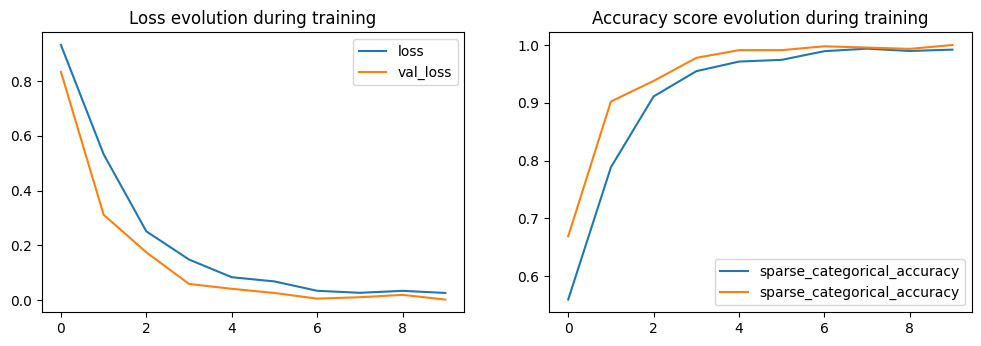

In [10]:
def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='loss')
    plt.plot(r.history['val_loss'], label='val_loss')
    plt.title('Loss evolution during training')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
    plt.plot(r.history['val_sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
    plt.title('Accuracy score evolution during training')
    plt.legend();

plot_learning_evolution(history)

In [11]:
my_model.evaluate(test_ds)

12/12 [==============================] - 1s 46ms/step - loss: 0.0014 - sparse_categorical_accuracy: 1.0000


[0.0013837618753314018, 1.0]

**Final test accuracy: 1.0000**